In [6]:
import simulator as sm
import os
import numpy as np
from datetime import date 
import matplotlib.pyplot as plt
import astropy.units as U
from natsort import natsorted

In [9]:
reference_dir = "/home/astro/Documents/ivano_test_images"
files = natsorted(os.listdir(reference_dir))
for file in files:
    print(file)
times = [4.27 * 60, 1.85 * 60, 4.88 * 50, 5.15 * 60,  5.15 * 60, 3.47 * 60, 14.25 * 60]
print(times)

uid___A002_Xb5aa7c_X2937.ms.split.cal.J1041+0610_B3.pseudocont.sc.fits
uid___A002_Xb5bd46_X5dc8.ms.split.cal.J1126-3828_B3.pseudocont.sc.fits
uid___A002_Xb88fca_X7028.ms.split.cal.J1319-1217_B3.pseudocont.sc.fits
uid___A002_Xb00171_X1904.ms.split.cal.J0438+3004_B3.pseudocont.sc.fits
uid___A002_Xc3a8fe_X280b.ms.J1229+0203_B3.pseudocont.sc.fits
uid___A002_Xc8ed16_X9686.ms.split.cal.J0442-0017_B3.pseudocont.sc.fits
uid___A002_Xef4e78_X19df.ms.split.cal.J0215-0222_B3.pseudocont.sc.fits
[256.2, 111.0, 244.0, 309.0, 309.0, 208.20000000000002, 855.0]


In [5]:
image, hdr = sm.load_fits(os.path.join(reference_dir, files[0]))
for key, value in hdr.items():
    print(key, value)
print(image.shape)

SIMPLE True
BITPIX -32
NAXIS 4
NAXIS1 256
NAXIS2 256
NAXIS3 1
NAXIS4 1
EXTEND True
BSCALE 1.0
BZERO 0.0
BMAJ 0.001189941565196
BMIN 0.0006211676862505
BPA -41.66469573975
BTYPE Intensity
OBJECT J0438+3004
 
BUNIT Jy/beam
RADESYS ICRS
LONPOLE 180.0
LATPOLE 30.07931055278
PC01_01 1.0
PC02_01 0.0
PC03_01 0.0
PC04_01 0.0
PC01_02 0.0
PC02_02 1.0
PC03_02 0.0
PC04_02 0.0
PC01_03 0.0
PC02_03 0.0
PC03_03 1.0
PC04_03 0.0
PC01_04 0.0
PC02_04 0.0
PC03_04 0.0
PC04_04 1.0
CTYPE1 RA---SIN
CRVAL1 69.52061791667
CDELT1 -0.000342315120287
CRPIX1 129.0
CUNIT1 deg
CTYPE2 DEC--SIN
CRVAL2 30.07931055278
CDELT2 0.000342315120287
CRPIX2 129.0
CUNIT2 deg
CTYPE3 FREQ
CRVAL3 86283954152.18
CDELT3 3795791988.424
CRPIX3 1.0
CUNIT3 Hz
CTYPE4 STOKES
CRVAL4 1.0
CDELT4 1.0
CRPIX4 1.0
CUNIT4 
PV2_1 0.0
PV2_2 0.0
RESTFRQ 86074497000.0
SPECSYS TOPOCENT
ALTRVAL -729527.0572327
ALTRPIX 1.0
VELREF 259
COMMENT casacore non-standard usage: 4 LSD, 5 GEO, 6 SOU, 7 GAL
TELESCOP ALMA
OBSERVER 2.82239998182
DATE-OBS 2016-03-02T00:

In [ ]:
clean, hdr = sm.load_fits('/home/astro/Documents/casa-data/sim-examples/clean_cube_1.fits')
print(clean.shape)
plt.imshow(np.sum(clean[0, :, :], axis=0))
n_pxs = 256
left = int((clean.shape[-1] - n_pxs) / 2)
clean_cube = clean[:, :,  left:left+n_pxs, left:left+n_pxs]
print(clean_cube.shape)
plt.imshow(np.sum(clean_cube[0, :, :], axis=0))

In [17]:
import simulator as sm
import os
import numpy as np
from datetime import date 
import matplotlib.pyplot as plt
import astropy.units as U
from casatasks import exportfits, simobserve, tclean

cycle = 3
antenna_config = 4
band = 3
main_path = '/home/astro/Documents/GitHub/ALMASim'
cycle_name = 'cycle{}'.format(int(cycle))
antenna_name = 'alma.cycle{}.0.{}'.format(cycle, antenna_config)
antennalist = os.path.join(main_path, "antenna_config", cycle_name, antenna_name + '.cfg')
spatial_resolution = sm.get_spatial_resolution(band, antenna_config)
print('Spatial Resolution:', spatial_resolution)
central_freq= sm.get_band_central_freq(band)
print('Central Frequency: ', central_freq)
fov = sm.get_fov([band])[0]
pixel_size = spatial_resolution / 7
print('Pixel Size:', pixel_size)
print('Field of View:', fov)
n_px = 256
max_baseline = sm.get_max_baseline_from_antenna_config(antennalist)
central_freq = sm.get_band_central_freq(band)
beam_size = sm.compute_beam_size_from_max_baseline(max_baseline, central_freq)
cell_size = beam_size / 5
print('Cell Size: ', cell_size)
bandwidth = 1000
inwidth = 10
fwhm_x = 10 * cell_size * np.random.rand() + cell_size
fwhm_y = 10 * cell_size  * np.random.rand() + cell_size
fwhm_z = 0.1 * bandwidth * np.random.rand() + inwidth
print('FWHM X:', fwhm_x)
print('FWHM Y:', fwhm_y)
print('FWHM Z:', fwhm_z)
n_channels = int(bandwidth / inwidth)
print('Number of Channels:', n_channels)
i = 0
output_dir = '/home/astro/Documents/casa-data/sim-examples'
n_sources = 0
ra, dec = 0, 0
pa = 128
min_sep_spatial = 0
min_sep_frequency = 0
rest_frequency = 1440.4
serendipitous = False
plot_dir = '/home/astro/Documents/casa-data/sim-examples/plots'
filename = sm.generate_gaussian_skymodel(i, output_dir, n_sources,
                                                  n_px, n_channels, bandwidth, 
                                                  fwhm_x * U.arcsec, fwhm_y * U.arcsec, 
                                                  fwhm_z * U.MHz,
                                                  cell_size * U.arcsec,  
                                                  fov * U.arcsec, 
                                                  spatial_resolution * U.arcsec, 
                                                  central_freq * U.GHz,
                                                  inwidth * U.GHz,
                                                  ra * U.deg, dec * U.deg,
                                                  pa, 
                                                  min_sep_spatial, 
                                                  min_sep_frequency,
                                                  rest_frequency, 
                                                  serendipitous,
                                                  plot_dir)

totaltime = 1.85 * 60
project = 'sim-examples'
simobserve(
    skymodel=filename,
    project=project,
    indirection="J2000 19h30m00 -40d00m00",
    incell="{}arcsec".format(cell_size),
    incenter='{}GHz'.format(central_freq),
    inwidth="{}MHz".format(inwidth),
    inbright="0.001Jy/pixel",
    setpointings=True,
    obsmode='int',
    antennalist=antennalist,
    totaltime="{}s".format(totaltime),
    integration="{0}s".format(totaltime),
    graphics='none',
    overwrite=True,
    thermalnoise="tsys-atm",
)


Spatial Resolution: 0.92
Central Frequency:  100
Pixel Size: 0.13142857142857142
Field of View: 58.22949632332764
Cell Size:  0.0625730155833181
FWHM X: 0.2651766752859105
FWHM Y: 0.312700926832439
FWHM Z: 72.07793757557562
Number of Channels: 100
4 4 7
Number of Pixels 256
Generating central source at position (127, 127, 50)
Skymodel saved to /home/astro/Documents/casa-data/sim-examples/skymodel_0.fits


In [18]:
tclean(
    vis=os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
    imagename=os.path.join(project, '{}.{}'.format(project, antenna_name)),
    imsize=[n_px, n_px],
    cell="{}arcsec".format(cell_size),
    specmode="cube",
    niter=0,
    fastnoise=False,
    calcpsf=True,
    pbcor=True,
    pblimit=0.2,
)

2023-09-19 15:31:23	WARN	task_tclean::SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2265)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


{}

In [19]:
exportfits(imagename=os.path.join(project, '{}.{}.image'.format(project, antenna_name)), 
           fitsimage=os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"), overwrite=True)
exportfits(imagename=os.path.join(project, '{}.{}.skymodel'.format(project, antenna_name)), 
           fitsimage=os.path.join(output_dir, "clean_cube_" + str(i) +".fits"), overwrite=True)

(1, 100, 256, 256) (1, 100, 256, 256)


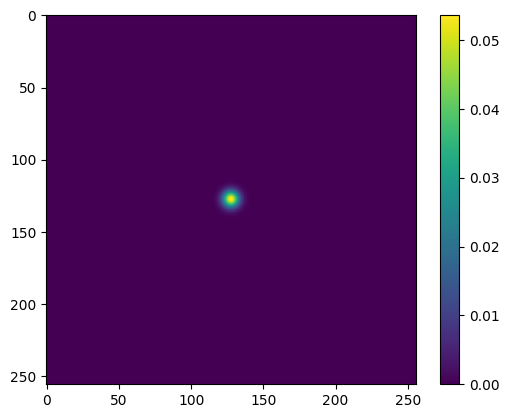

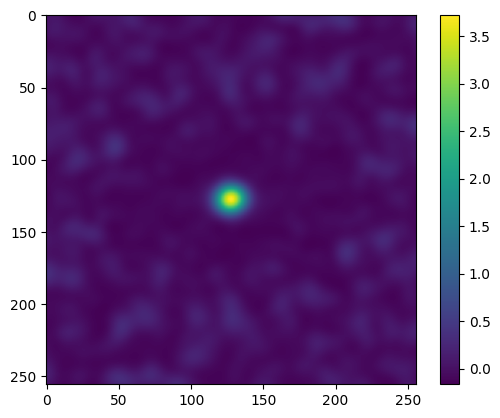

In [20]:
clean, clean_header = sm.load_fits(os.path.join(output_dir, "clean_cube_" + str(i) +".fits"))
dirty, dirty_header = sm.load_fits(os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"))
print(clean.shape, dirty.shape)

plt.figure()
plt.imshow(np.sum(clean[0, :, :], axis=0))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.sum(dirty[0, :, :], axis=0))
plt.colorbar()
plt.show()

In [87]:
import simulator as sm
antennalist = "/home/astro/Documents/GitHub/ALMASim/antenna_config/cycle9/alma.cycle9.0.10.cfg" 
max_baseline = sm.get_max_baseline_from_antenna_config(antennalist)
central_freq = sm.get_band_central_freq(band)
beam_size = sm.compute_beam_size_from_max_baseline(max_baseline, central_freq)
cell_size = beam_size / 5
print(max_baseline, beam_size)

16.259065286279284 0.04674315445681552
